## Assignment: Размещение баннеров

Представим, что международное круизное агентство "Carnival Cruise Line" решило себя разрекламировать с помощью баннеров и обратилось для этого к Вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с Вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры - легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях - Foursqare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив с этой страницы.

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:

id | user_id | venue_id | latitude | longitude | created_at

---------+---------+----------+-------------------+-------------------+---------------------

984301 | 2041916 | 5222 | | | 2012-04-21 17:39:01

984222 | 15824 | 5222 | 38.8951118 | -77.0363658 | 2012-04-21 17:43:47

984315 | 1764391 | 5222 | | | 2012-04-21 17:37:18

984234 | 44652 | 5222 | 33.800745 | -84.41052 | 2012-04-21 17:43:43

...

Для удобной работы с этим документом преобразуем его к формату csv, удалив строки не содержащие координат - они неинформативны для нас:

id,user_id,venue_id,latitude,longitude,created_at

984222,15824,5222,38.8951118,-77.0363658,2012-04-21T17:43:47

984234,44652,5222,33.800745,-84.41052,2012-04-21T17:43:43

984291,105054,5222,45.5234515,-122.6762071,2012-04-21T17:39:22

...

С помощью pandas построим DataFrame и убедимся, что все 396632 строк с координатами считаны успешно.

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача - хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в [sklearn user guide](http://scikit-learn.org/stable/modules/clustering.html#mean-shift), а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание: на 39663 строках, кластеризация будет работать долго. Для получения корректного ответа достаточно и 100000 (~2 минуты на "среднем" ноутбуке). Быть очень терпеливым не возбраняется - результат от этого только улучшится.

Некоторые из получившихся кластеров содержат слишком мало точек - такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте, можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:

38.8951118,-77.0363658

33.800745,-84.41052

45.5234515,-122.6762071

...

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу "Carnival Cruise Line" адреса офисов:

33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании - широта и долгота этого центра, записанные через пробел.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

def write_result(task_number, data) : 
    filename = "./results/result%s.txt" % task_number
    directory = os.path.dirname(filename)
    
    if not os.path.exists(directory):
        os.makedirs(directory)

    file = open(filename, 'w')
    for symbol in data:
        file.write(str(symbol) + ' ')
    file.close()

In [4]:
data = pd.read_csv('checkins.dat', sep='|', skiprows=[1], skipinitialspace=True).dropna()

In [5]:
data.head()

,id,user_id,venue_id,latitude,longitude,created_at
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
7,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
9,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
10,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [6]:
data = data.iloc[:, 3:5]
data.head()

,latitude,longitude
1,38.895112,-77.036366
3,33.800745,-84.410520
7,45.523452,-122.676207
9,40.764462,-111.904565
10,33.448377,-112.074037


In [7]:
data.shape

(396634, 2)

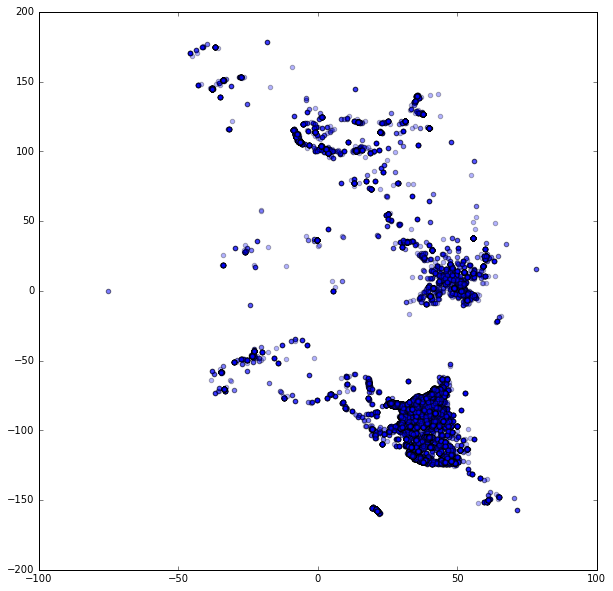

In [8]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], alpha=0.3)
plt.show()

In [9]:
bandwidth = 0.1
ms = MeanShift(bandwidth=bandwidth)
ms.fit(data)

MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=1, seeds=None)

In [10]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_counter = Counter(labels)

n_clusters = len(labels_counter.items())
print("number of estimated clusters : %d" % n_clusters)

number of estimated clusters : 5536


In [12]:
bad_clusters_index = np.array([])

for cluster_index, labels_n in labels_counter.iteritems():
    if (labels_n < 15) : 
        bad_clusters_index = np.append(bad_clusters_index, cluster_index)

clusters = np.delete(cluster_centers, bad_clusters_index, axis=0)

In [13]:
offices = np.array([[33.751277, -118.188740], [25.867736, -80.324116], [51.503016, -0.075479],
                   [52.378894, 4.885084], [39.366487, 117.036146], [-33.868457, 151.205134]])

In [14]:
nearest_clusters = np.empty(shape=(0,3))

for office in offices: 
    for cluster in clusters:
        dist = sqrt((cluster[0] - office[0])**2 + (cluster[1] - office[1])**2)
        nearest_clusters = np.vstack( (nearest_clusters, np.array([cluster[0], cluster[1], dist])) ) 
        
# sort by distance
nearest_clusters = nearest_clusters[nearest_clusters[:, 2].argsort()][0:20]

In [15]:
print("nearest cluster center = {0} : {1}".format(nearest_clusters[0][0], nearest_clusters[0][1]))

nearest cluster center = -33.8661460662 : 151.207082415


In [16]:
write_result(1, [nearest_clusters[0][0], nearest_clusters[0][1]])